In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.auto import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("/n/home12/binxuwang/Github/DiffusionLearningCurve")
sys.path.append("/Users/binxuwang/Github/DiffusionLearningCurve/")
from core.diffusion_nn_lib import UNetBlockStyleMLP_backbone
from core.toy_shape_dataset_lib import generate_random_star_shape_torch
from core.diffusion_basics_lib import *
from core.diffusion_edm_lib import *

In [3]:
import os
import pickle as pkl
from circuit_toolkit.plot_utils import saveallforms
saveroot = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve"

In [4]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    return device

### Training Demo

In [ ]:
pnts, radius_fun, amplitudes, phases = generate_random_star_shape_torch(1000, num_modes=10)
pnts = pnts.float()
device = get_device()
model = UNetBlockStyleMLP_backbone(ndim=2, nlayers=5, nhidden=64, time_embed_dim=64,)
model_precd = EDMPrecondWrapper(model, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=0.5)
model_precd, loss_traj = train_score_model_custom_loss(pnts, model_precd, edm_loss_fn, 
                                    lr=0.001, nepochs=2000, batch_size=1024, device=device)


  0%|          | 0/2000 [00:00<?, ?it/s]

step 0 loss 1.846


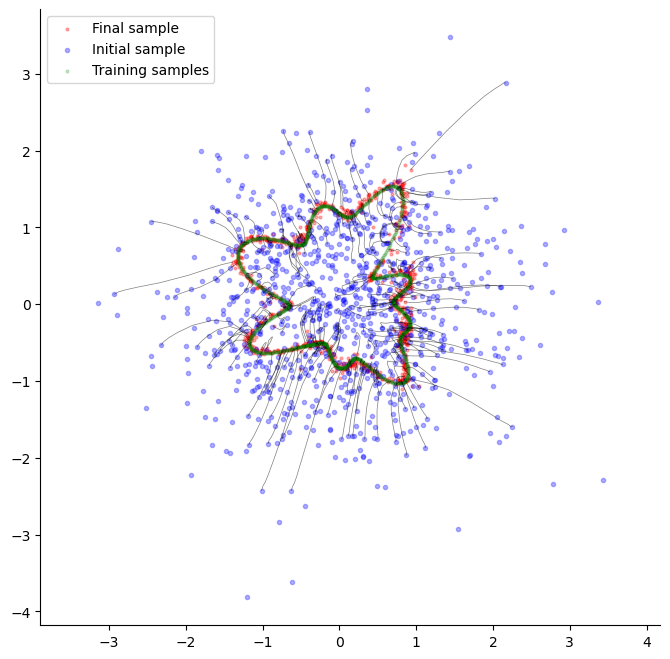

In [10]:
import os
from os.path import join
savetmpdir = join(saveroot, "star_shape_demo")
os.makedirs(savetmpdir, exist_ok=True)

noise_init = torch.randn(1000, 2).to(device)
x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model_precd, noise_init, 
                num_steps=20, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)

scaling = 1 / (t_steps ** 2 + 1).sqrt()
scaled_x_traj = (scaling[:, None, None] * x_traj).cpu()
plt.figure(figsize=[8,8])
plt.plot(scaled_x_traj[:, ::4, 0].numpy(), 
        scaled_x_traj[:, ::4, 1].numpy(), lw=0.5, color="k", alpha=0.5)
plt.scatter(scaled_x_traj[-1,:,0], scaled_x_traj[-1,:,1], c="red", s=4, marker='o', alpha=0.3, label="Final sample")
plt.scatter(scaled_x_traj[ 0,:,0], scaled_x_traj[ 0,:,1], c="blue", s=9, marker='o', alpha=0.3, label="Initial sample")
plt.scatter(pnts[:,0].cpu(), pnts[:,1].cpu(), c="green", s=4, marker='o', alpha=0.2, label="Training samples")
plt.axis("equal")
plt.legend()
saveallforms(saveroot, "demo_edm_sampler_star_shape")
plt.show()

### Gaussian Data Spectral convergence

In [7]:
!mkdir $STORE_DIR/DL_Projects/DiffusionSpectralLearningCurve

In [8]:
!echo $STORE_DIR/DL_Projects/DiffusionSpectralLearningCurve

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve


In [9]:
record_step_list = [*range(0, 10, 1), *range(10, 50, 2), *range(50, 100, 4), *range(100, 500, 8), *range(500, 2500, 16), 
                    *range(2500, 5000, 32), *range(5000, 10000, 64)]

True covariance trace 128.0
Estimated training sample covariance trace 127.91082763671875


/tmp/ipykernel_1128504/1695309836.py:24: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at /opt/conda/conda-bld/pytorch_1716905979055/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2416.)
  rot = torch.qr(torch.randn(ndim, ndim, device=device))[0]


  0%|          | 0/5000 [00:00<?, ?it/s]

step 0 loss 2.618


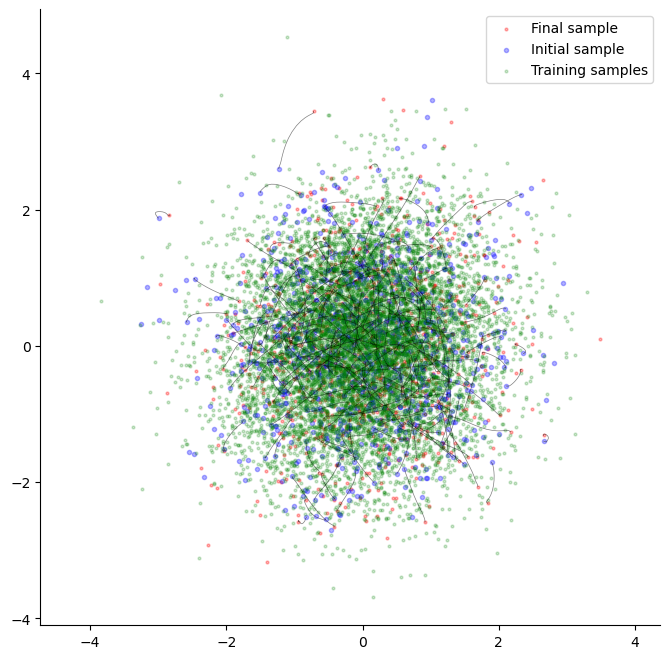

In [ ]:
sample_store = {}
loss_store = {}
def sampling_callback_fn(epoch, loss, model):
    loss_store[epoch] = loss
    noise_init = torch.randn(10000, ndim).to(device)
    x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model, noise_init, 
                    num_steps=20, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)
    sample_store[epoch] = x_out,

# pnts, radius_fun, amplitudes, phases = generate_random_star_shape_torch(1000, num_modes=10)
# create a 10 x 10 covariance matrix with non white spectrum
ndim = 256
savedir = f"{saveroot}/GaussianData/ndim{ndim}_small_lr_width256_export" # "
os.makedirs(savedir, exist_ok=True)
device = get_device()
# diag_var = torch.rand(ndim, device=device)
diag_var = torch.exp(torch.randn(ndim, device=device))
diag_var = torch.sort(diag_var, descending=True)[0]
diag_var = diag_var / diag_var.mean() 
diag_std = diag_var.sqrt()
cov = torch.diag(diag_var)
# rot = torch.eye(ndim, device=device)
# rotate the covariance matrix with a random rotation matrix
rot = torch.qr(torch.randn(ndim, ndim, device=device))[0]
cov = rot @ cov @ rot.T
pnts = torch.randn(10000, ndim).to(device)
pnts = pnts @ torch.diag(diag_std) @ rot.T
cov_empirical = torch.cov(pnts.T, correction=1)
print("True covariance trace", torch.trace(cov).item()) # ~ 10
print("Estimated training sample covariance trace", torch.trace(cov_empirical).item()) # ~ 13.2

pnts = pnts.float()
device = get_device()
model = UNetBlockStyleMLP_backbone(ndim=ndim, nlayers=5, nhidden=256, time_embed_dim=256,)
model_precd = EDMPrecondWrapper(model, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=0.5)
model_precd, loss_traj = train_score_model_custom_loss(pnts, model_precd, edm_loss_fn, 
                                    lr=0.0001, nepochs=5000, batch_size=1024, device=device, 
                                    callback=sampling_callback_fn, callback_freq=0, callback_step_list=record_step_list)

noise_init = torch.randn(1000, ndim).to(device)
x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model_precd, noise_init, 
                num_steps=40, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)

scaling = 1 / (t_steps ** 2 + 1).sqrt()
scaled_x_traj = (scaling[:, None, None] * x_traj).cpu()
plt.figure(figsize=[8, 8])
plt.plot(scaled_x_traj[:, ::4, 0].numpy(), 
        scaled_x_traj[:, ::4, 1].numpy(), lw=0.5, color="k", alpha=0.5)
plt.scatter(scaled_x_traj[-1,:,0], scaled_x_traj[-1,:,1], c="red", s=4, marker='o', alpha=0.3, label="Final sample")
plt.scatter(scaled_x_traj[ 0,:,0], scaled_x_traj[ 0,:,1], c="blue", s=9, marker='o', alpha=0.3, label="Initial sample")
plt.scatter(pnts[:,0].cpu(), pnts[:,1].cpu(), c="green", s=4, marker='o', alpha=0.2, label="Training samples")
plt.axis("equal")
plt.legend()
plt.show()

pkl.dump(sample_store, open(f"{savedir}/sample_store.pkl", "wb"))
pkl.dump(loss_store, open(f"{savedir}/loss_store.pkl", "wb"))
torch.save(model_precd.model.state_dict(), f"{savedir}/model_final.pth")
pkl.dump({"diag_var": diag_var.cpu(), 
          "rot": rot.cpu(), 
          "cov": cov.cpu(), 
          "cov_empirical": cov_empirical.cpu(),
          "train_pnts": pnts.cpu()}, open(f"{savedir}/train_data_cov_info.pkl", "wb"))

### Final analysis

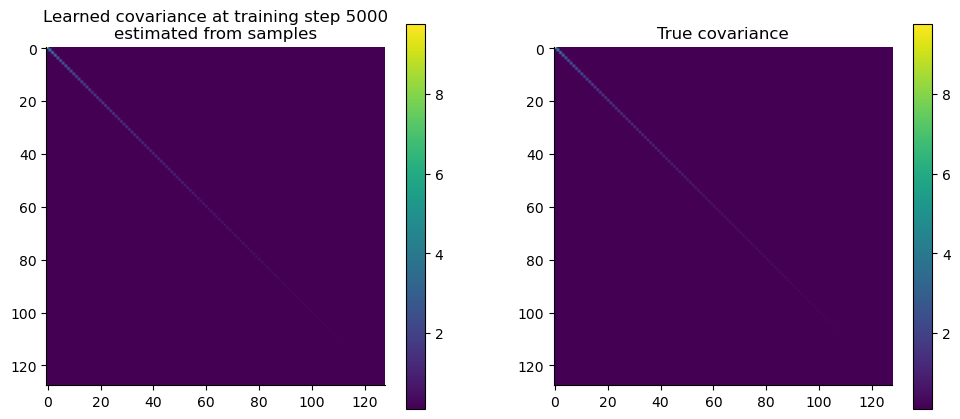

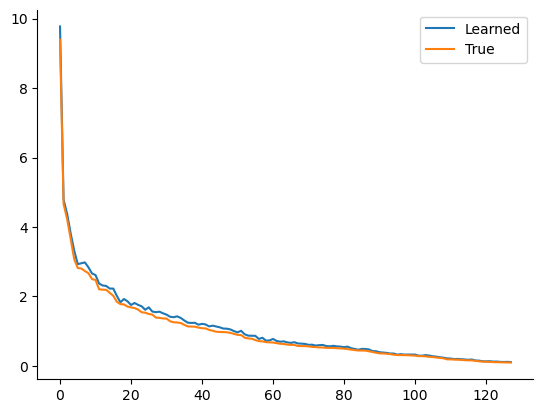

In [15]:
training_step = 5000
x_out, = sample_store[training_step]
cov_x_sample = torch.cov(x_out.T).to(device)
# try estimate the variance along the eigenvector of the covariance matrix
cov_x_sample_true_eigenbasis = rot.T @ cov_x_sample @ rot
cov_true_eigenbasis = rot.T @ cov @ rot
diag_cov_x_sample_true_eigenbasis = torch.diag(cov_x_sample_true_eigenbasis)
diag_cov_true_eigenbasis = torch.diag(cov_true_eigenbasis)

vmin = min(diag_cov_x_sample_true_eigenbasis.min(), diag_cov_true_eigenbasis.min())
vmax = max(diag_cov_x_sample_true_eigenbasis.max(), diag_cov_true_eigenbasis.max())
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(cov_x_sample_true_eigenbasis.cpu().numpy(), vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(f"Learned covariance at training step {training_step}\nestimated from samples")
plt.subplot(122)
plt.imshow(cov_true_eigenbasis.cpu().numpy(), vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title("True covariance")
plt.show()
plt.plot(diag_cov_x_sample_true_eigenbasis.cpu().numpy(), label="Learned")
plt.plot(diag_cov_true_eigenbasis.cpu().numpy(), label="True")
plt.legend()
plt.show()

### Visualization 128d

In [16]:
from core.trajectory_convergence_lib import smooth_and_find_threshold_crossing, compute_crossing_points
from core.img_patch_stats_analysis_lib import plot_variance_trajectories, process_img_mean_cov_statistics

In [ ]:
figdir = "/n/home12/binxuwang/Github/DiffusionLearningCurve/figures/MLP_Gaussian_figs"
expname = "Gaussian_128d"
step_slice = sorted(list(sample_store))


In [18]:
figdir = "/n/home12/binxuwang/Github/DiffusionLearningCurve/figures/MLP_Gaussian_figs"
expname = "Gaussian_128d"
step_slice = sorted(list(sample_store))

img_mean, img_cov, img_eigval, img_eigvec, mean_x_sample_traj, cov_x_sample_traj, diag_cov_x_sample_true_eigenbasis_traj = \
     process_img_mean_cov_statistics(pnts, sample_store, savedir, device="cuda", imgshape=(ndim,), save_pkl=False)

img_cov.shape: torch.Size([128, 128]) computed on 10000 images


  0%|          | 0/297 [00:00<?, ?it/s]

In [19]:
emer_time_df = compute_crossing_points(img_eigval.cpu(), diag_cov_x_sample_true_eigenbasis_traj.cpu(), range(len(step_slice)), smooth_sigma=1, threshold_type="geometric_mean")

In [20]:
# find the eigen index that the initial variance and final variance are similar
var_ratio = diag_cov_x_sample_true_eigenbasis_traj[0,:] / img_eigval.cpu()
eig_idx_tooclose = (var_ratio > 0.5) & (var_ratio < 2)
eig_idx_tooclose_vec = eig_idx_tooclose.nonzero()[:,0]

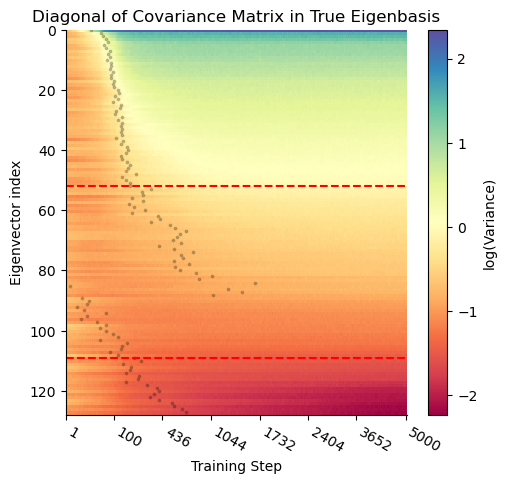

In [24]:
plt.figure(figsize=(5.5, 5))
plt.pcolor(diag_cov_x_sample_true_eigenbasis_traj.log().cpu().numpy().T, cmap="Spectral", rasterized=True)
plt.colorbar(label="log(Variance)")
plt.scatter(emer_time_df["emergence_step"].to_numpy(), emer_time_df.index.to_numpy(), marker="o", c="k", s=3, alpha=0.2, rasterized=True)
plt.axhline(eig_idx_tooclose_vec[0], color="r", linestyle="--")
plt.axhline(eig_idx_tooclose_vec[-1], color="r", linestyle="--")
plt.title("Diagonal of Covariance Matrix in True Eigenbasis")
plt.xlabel("Training Step")
plt.ylabel("Eigenvector index")
plt.gca().invert_yaxis()  # Flip the y-axis
# annotate x-axis with step_slice
# Only show a subset of ticks to avoid overcrowding
tick_indices = np.linspace(0, len(step_slice)-1, 8, dtype=int)
plt.xticks(tick_indices, [step_slice[i] for i in tick_indices], rotation=-30, ha="left")
saveallforms(figdir, f"eigenframe_variance_heatmap_{expname}_rasterized", dpi=300)
plt.show()

In [25]:
from core.trajectory_convergence_lib import fit_regression_log_scale, analyze_and_plot_variance

Direction: increase
Slope: -0.76, Intercept: 5.15, R-squared: 0.89 (log-log) [N=52]
Equation: $y = 172.09 x^{-0.76}$
Direction: decrease
Slope: -1.64, Intercept: 2.46, R-squared: 0.81 (log-log) [N=20]
Equation: $y = 11.74 x^{-1.64}$


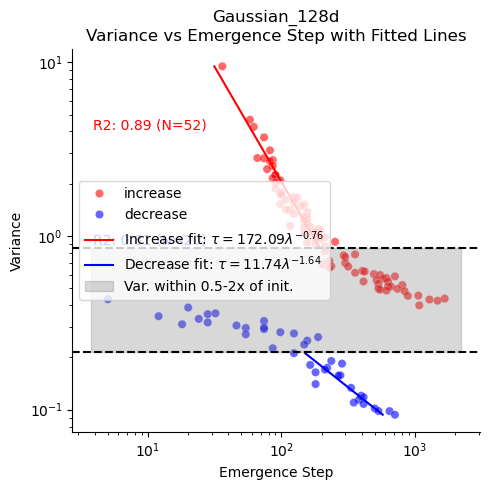

In [26]:
emer_time_df_step = compute_crossing_points(img_eigval.cpu(), diag_cov_x_sample_true_eigenbasis_traj.cpu(), step_slice, smooth_sigma=1, threshold_type="geometric_mean")

init_var = diag_cov_x_sample_true_eigenbasis_traj[0,:]
mean_init_var = init_var.mean().item()
exclude_mask = (emer_time_df_step.Variance / mean_init_var > 0.5) & (emer_time_df_step.Variance / mean_init_var < 2)

analyze_and_plot_variance(emer_time_df_step, x_col="emergence_step", y_col="Variance", hue_col="Direction", log_x=True, log_y=True, figsize=(5, 5), 
                          exclude_mask=exclude_mask, reverse_equation=True, fit_label_format='{direction} fit: $\\tau = {a:.2f} \lambda^{{{b:.2f}}}$', 
                          title=f'{expname}\nVariance vs Emergence Step with Fitted Lines', xlabel='Emergence Step', ylabel='Variance', 
                          alpha=0.6, annotate=False, annotate_offset=(0, 0), fit_line_kwargs=None, 
                          scatter_kwargs={"rasterized": True, "linewidth": 0.3}, 
                          ax=None,
                          )
plt.axhline(0.5 * mean_init_var, color="k", linestyle="--")
plt.axhline(2 * mean_init_var, color="k", linestyle="--")
# fill the area between the two lines
XLIM = plt.gca().get_xlim()
plt.fill_betweenx([0.5 * mean_init_var, 2 * mean_init_var], [XLIM[0], XLIM[0]], [XLIM[1], XLIM[1]], 
                  color="gray", alpha=0.3, label="Var. within 0.5-2x of init.")
print("Direction: increase",)
df_split = emer_time_df_step[~exclude_mask].query("Direction == 'increase'")
fit_dict_increase = fit_regression_log_scale(df_split.Variance, df_split.emergence_step)
print("Direction: decrease",)
df_split = emer_time_df_step[~exclude_mask].query("Direction == 'decrease'")
fit_dict_decrease = fit_regression_log_scale(df_split.Variance, df_split.emergence_step)
# annotate the R2 of the fit
plt.text(0.05, 0.8, f"R2: {fit_dict_increase['r_squared']:.2f} (N={fit_dict_increase['N']})", transform=plt.gca().transAxes, ha="left", va="center", color="r")
plt.text(0.05, 0.5, f"R2: {fit_dict_decrease['r_squared']:.2f} (N={fit_dict_decrease['N']})", transform=plt.gca().transAxes, ha="left", va="center", color="blue")
plt.legend()
saveallforms(figdir, f"convergence_time_vs_variance_scaling_{expname}_rasterized", dpi=300)
plt.show()

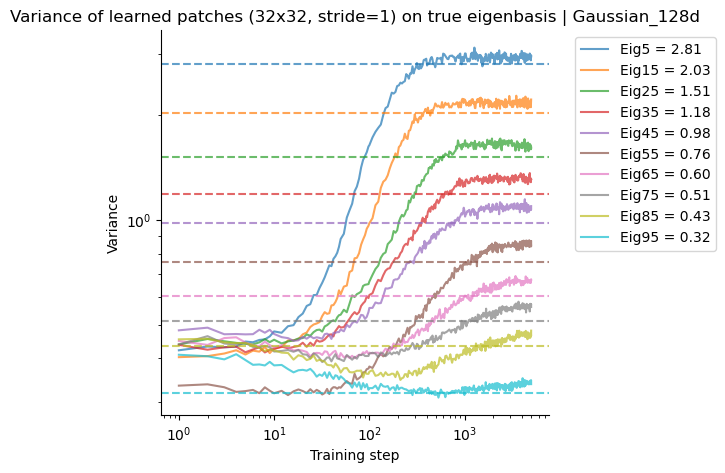

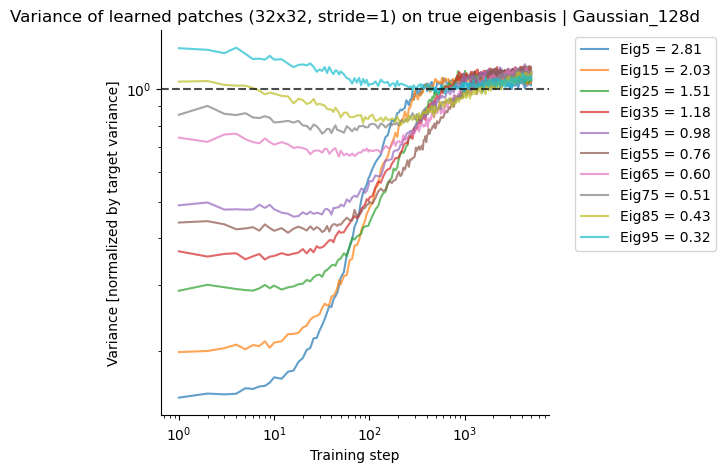

In [27]:
plot_variance_trajectories(step_slice, diag_cov_x_sample_true_eigenbasis_traj.cpu(), img_eigval.cpu(), 
                           slice(5, 100, 10), 32, 1, figdir, expname, figsize=(5, 5))

### 256d

In [ ]:
record_step_list = [*range(0, 10, 1), *range(10, 50, 2), *range(50, 100, 4), *range(100, 500, 8), *range(500, 2500, 16), 
                    *range(2500, 5000, 32), *range(5000, 10000, 64)]

True covariance trace 256.0
Estimated training sample covariance trace 255.6614227294922


  0%|          | 0/5000 [00:00<?, ?it/s]

step 0 loss 3.330


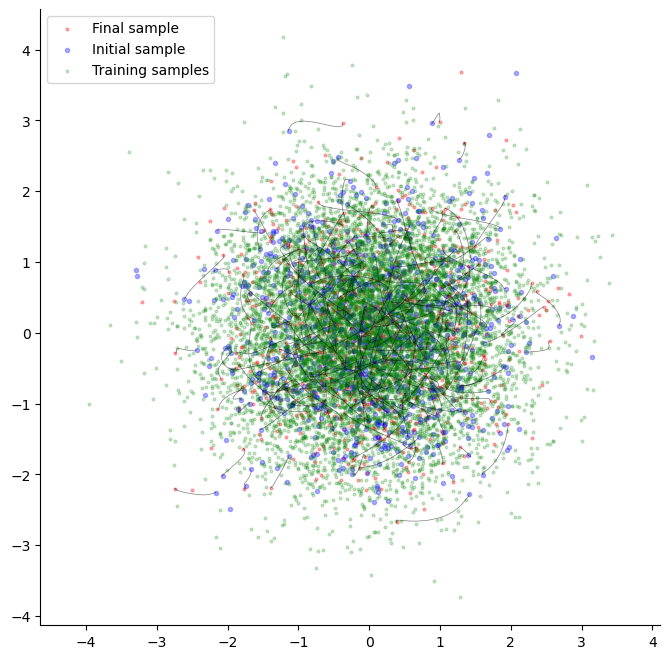

In [28]:
sample_store = {}
loss_store = {}
def sampling_callback_fn(epoch, loss, model):
    loss_store[epoch] = loss
    noise_init = torch.randn(10000, ndim).to(device)
    x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model, noise_init, 
                    num_steps=20, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)
    sample_store[epoch] = x_out,

# pnts, radius_fun, amplitudes, phases = generate_random_star_shape_torch(1000, num_modes=10)
# create a 10 x 10 covariance matrix with non white spectrum
ndim = 256
savedir = f"{saveroot}/GaussianData/ndim{ndim}_small_lr_width256_export" # "
os.makedirs(savedir, exist_ok=True)
device = get_device()
# diag_var = torch.rand(ndim, device=device)
diag_var = torch.exp(torch.randn(ndim, device=device))
diag_var = torch.sort(diag_var, descending=True)[0]
diag_var = diag_var / diag_var.mean() 
diag_std = diag_var.sqrt()
cov = torch.diag(diag_var)
# rot = torch.eye(ndim, device=device)
# rotate the covariance matrix with a random rotation matrix
rot = torch.qr(torch.randn(ndim, ndim, device=device))[0]
cov = rot @ cov @ rot.T
pnts = torch.randn(10000, ndim).to(device)
pnts = pnts @ torch.diag(diag_std) @ rot.T
cov_empirical = torch.cov(pnts.T, correction=1)
print("True covariance trace", torch.trace(cov).item()) # ~ 10
print("Estimated training sample covariance trace", torch.trace(cov_empirical).item()) # ~ 13.2

pnts = pnts.float()
device = get_device()
model = UNetBlockStyleMLP_backbone(ndim=ndim, nlayers=5, nhidden=256, time_embed_dim=256,)
model_precd = EDMPrecondWrapper(model, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=0.5)
model_precd, loss_traj = train_score_model_custom_loss(pnts, model_precd, edm_loss_fn, 
                                    lr=0.0001, nepochs=5000, batch_size=1024, device=device, 
                                    callback=sampling_callback_fn, callback_freq=0, callback_step_list=record_step_list)

noise_init = torch.randn(1000, ndim).to(device)
x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model_precd, noise_init, 
                num_steps=40, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)

scaling = 1 / (t_steps ** 2 + 1).sqrt()
scaled_x_traj = (scaling[:, None, None] * x_traj).cpu()
plt.figure(figsize=[8, 8])
plt.plot(scaled_x_traj[:, ::4, 0].numpy(), 
        scaled_x_traj[:, ::4, 1].numpy(), lw=0.5, color="k", alpha=0.5)
plt.scatter(scaled_x_traj[-1,:,0], scaled_x_traj[-1,:,1], c="red", s=4, marker='o', alpha=0.3, label="Final sample")
plt.scatter(scaled_x_traj[ 0,:,0], scaled_x_traj[ 0,:,1], c="blue", s=9, marker='o', alpha=0.3, label="Initial sample")
plt.scatter(pnts[:,0].cpu(), pnts[:,1].cpu(), c="green", s=4, marker='o', alpha=0.2, label="Training samples")
plt.axis("equal")
plt.legend()
plt.show()

pkl.dump(sample_store, open(f"{savedir}/sample_store.pkl", "wb"))
pkl.dump(loss_store, open(f"{savedir}/loss_store.pkl", "wb"))
torch.save(model_precd.model.state_dict(), f"{savedir}/model_final.pth")
pkl.dump({"diag_var": diag_var.cpu(), 
          "rot": rot.cpu(), 
          "cov": cov.cpu(), 
          "cov_empirical": cov_empirical.cpu(),
          "train_pnts": pnts.cpu()}, open(f"{savedir}/train_data_cov_info.pkl", "wb"))

In [31]:
from os.path import join

In [33]:
figdir = "/n/home12/binxuwang/Github/DiffusionLearningCurve/figures/MLP_Gaussian_figs_256d"
os.makedirs(figdir)
expname = "Gaussian_256d"
step_slice = sorted(list(sample_store))

img_mean, img_cov, img_eigval, img_eigvec, mean_x_sample_traj, cov_x_sample_traj, diag_cov_x_sample_true_eigenbasis_traj = \
     process_img_mean_cov_statistics(pnts, sample_store, savedir, device="cuda", imgshape=(ndim,), save_pkl=False)

img_cov.shape: torch.Size([256, 256]) computed on 10000 images


  0%|          | 0/297 [00:00<?, ?it/s]

In [34]:
emer_time_df = compute_crossing_points(img_eigval.cpu(), diag_cov_x_sample_true_eigenbasis_traj.cpu(), range(len(step_slice)), smooth_sigma=1, threshold_type="geometric_mean")
emer_time_df.to_csv(join(figdir, "var_vs_emergence_time_df.csv"))

No crossing found for mode 120
No crossing found for mode 122
No crossing found for mode 125
No crossing found for mode 126
No crossing found for mode 127
No crossing found for mode 128
No crossing found for mode 137
No crossing found for mode 140
No crossing found for mode 142


In [35]:
# find the eigen index that the initial variance and final variance are similar
var_ratio = diag_cov_x_sample_true_eigenbasis_traj[0,:] / img_eigval.cpu()
eig_idx_tooclose = (var_ratio > 0.5) & (var_ratio < 2)
eig_idx_tooclose_vec = eig_idx_tooclose.nonzero()[:,0]

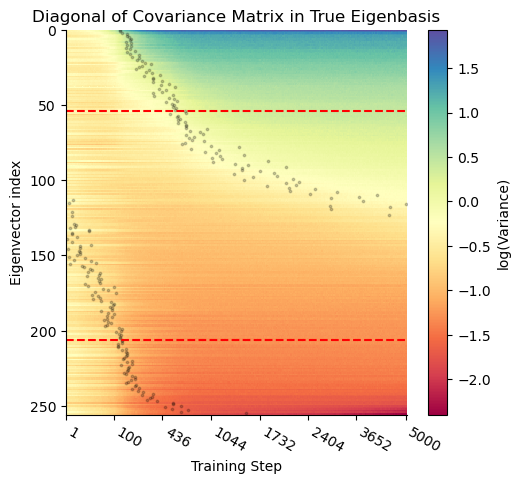

In [36]:
plt.figure(figsize=(5.5, 5))
plt.pcolor(diag_cov_x_sample_true_eigenbasis_traj.log().cpu().numpy().T, cmap="Spectral", rasterized=True)
plt.colorbar(label="log(Variance)")
plt.scatter(emer_time_df["emergence_step"].to_numpy(), emer_time_df.index.to_numpy(), marker="o", c="k", s=3, alpha=0.2, rasterized=True)
plt.axhline(eig_idx_tooclose_vec[0], color="r", linestyle="--")
plt.axhline(eig_idx_tooclose_vec[-1], color="r", linestyle="--")
plt.title("Diagonal of Covariance Matrix in True Eigenbasis")
plt.xlabel("Training Step")
plt.ylabel("Eigenvector index")
plt.gca().invert_yaxis()  # Flip the y-axis
# annotate x-axis with step_slice
# Only show a subset of ticks to avoid overcrowding
tick_indices = np.linspace(0, len(step_slice)-1, 8, dtype=int)
plt.xticks(tick_indices, [step_slice[i] for i in tick_indices], rotation=-30, ha="left")
saveallforms(figdir, f"eigenframe_variance_heatmap_{expname}_rasterized", dpi=300)
plt.show()

In [37]:
from core.trajectory_convergence_lib import fit_regression_log_scale, analyze_and_plot_variance

No crossing found for mode 120
No crossing found for mode 122
No crossing found for mode 125
No crossing found for mode 126
No crossing found for mode 127
No crossing found for mode 128
No crossing found for mode 137
No crossing found for mode 140
No crossing found for mode 142
Not enough data points to fit for direction: nan
Direction: increase
Slope: -1.08, Intercept: 6.70, R-squared: 0.92 (log-log) [N=64]
Equation: $y = 810.66 x^{-1.08}$
Direction: decrease
Slope: -1.08, Intercept: 3.43, R-squared: 0.91 (log-log) [N=63]
Equation: $y = 31.01 x^{-1.08}$


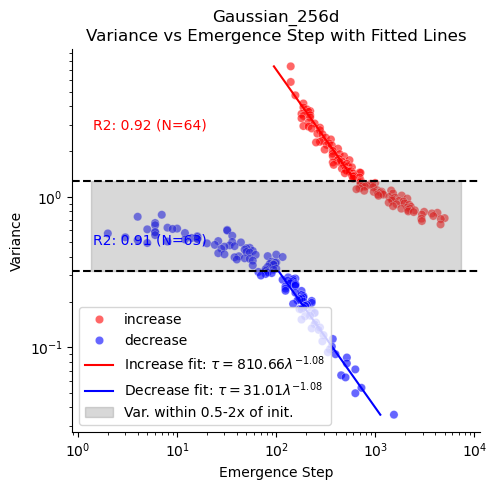

In [38]:
emer_time_df_step = compute_crossing_points(img_eigval.cpu(), diag_cov_x_sample_true_eigenbasis_traj.cpu(), step_slice, smooth_sigma=1, threshold_type="geometric_mean")

init_var = diag_cov_x_sample_true_eigenbasis_traj[0,:]
mean_init_var = init_var.mean().item()
exclude_mask = (emer_time_df_step.Variance / mean_init_var > 0.5) & (emer_time_df_step.Variance / mean_init_var < 2)

analyze_and_plot_variance(emer_time_df_step, x_col="emergence_step", y_col="Variance", hue_col="Direction", log_x=True, log_y=True, figsize=(5, 5), 
                          exclude_mask=exclude_mask, reverse_equation=True, fit_label_format='{direction} fit: $\\tau = {a:.2f} \lambda^{{{b:.2f}}}$', 
                          title=f'{expname}\nVariance vs Emergence Step with Fitted Lines', xlabel='Emergence Step', ylabel='Variance', 
                          alpha=0.6, annotate=False, annotate_offset=(0, 0), fit_line_kwargs=None, 
                          scatter_kwargs={"rasterized": True, "linewidth": 0.3}, 
                          ax=None,
                          )
plt.axhline(0.5 * mean_init_var, color="k", linestyle="--")
plt.axhline(2 * mean_init_var, color="k", linestyle="--")
# fill the area between the two lines
XLIM = plt.gca().get_xlim()
plt.fill_betweenx([0.5 * mean_init_var, 2 * mean_init_var], [XLIM[0], XLIM[0]], [XLIM[1], XLIM[1]], 
                  color="gray", alpha=0.3, label="Var. within 0.5-2x of init.")
print("Direction: increase",)
df_split = emer_time_df_step[~exclude_mask].query("Direction == 'increase'")
fit_dict_increase = fit_regression_log_scale(df_split.Variance, df_split.emergence_step)
print("Direction: decrease",)
df_split = emer_time_df_step[~exclude_mask].query("Direction == 'decrease'")
fit_dict_decrease = fit_regression_log_scale(df_split.Variance, df_split.emergence_step)
# annotate the R2 of the fit
plt.text(0.05, 0.8, f"R2: {fit_dict_increase['r_squared']:.2f} (N={fit_dict_increase['N']})", transform=plt.gca().transAxes, ha="left", va="center", color="r")
plt.text(0.05, 0.5, f"R2: {fit_dict_decrease['r_squared']:.2f} (N={fit_dict_decrease['N']})", transform=plt.gca().transAxes, ha="left", va="center", color="blue")
plt.legend()
saveallforms(figdir, f"convergence_time_vs_variance_scaling_{expname}_rasterized", dpi=300)
plt.show()

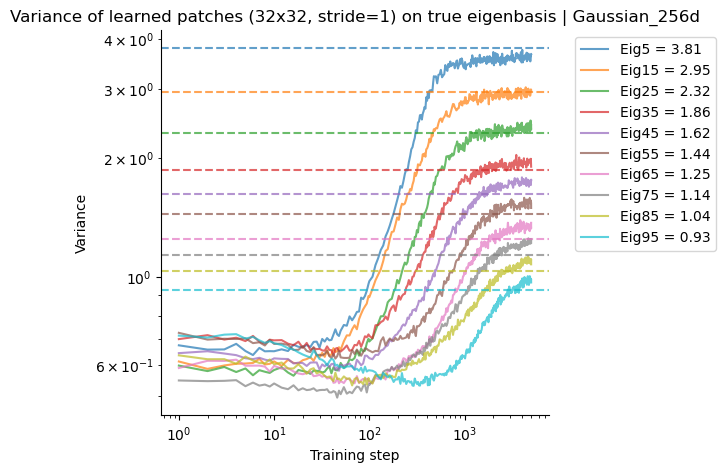

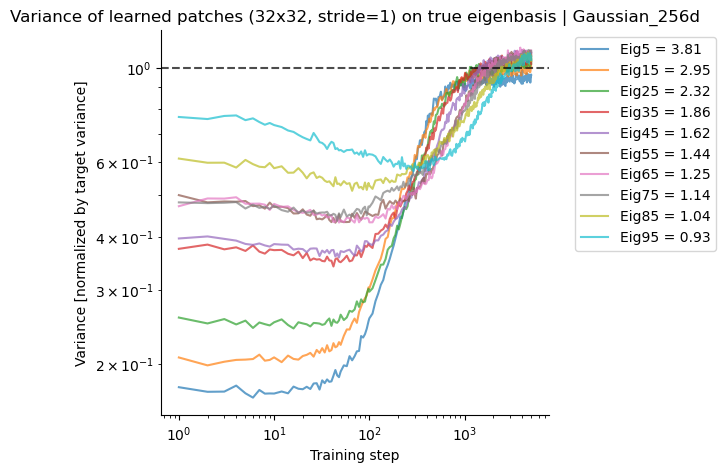

In [39]:
plot_variance_trajectories(step_slice, diag_cov_x_sample_true_eigenbasis_traj.cpu(), img_eigval.cpu(), 
                           slice(5, 100, 10), 32, 1, figdir, expname, figsize=(5, 5))

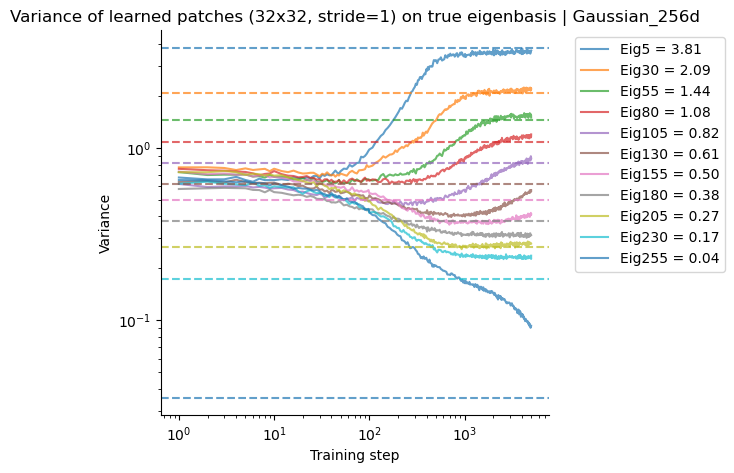

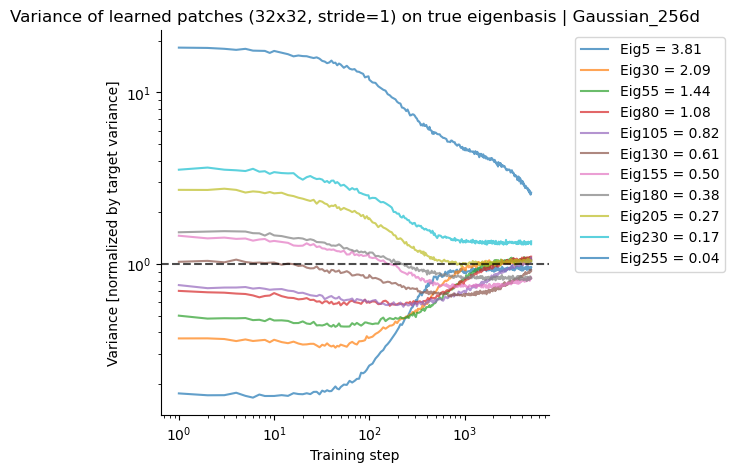

In [40]:
plot_variance_trajectories(step_slice, diag_cov_x_sample_true_eigenbasis_traj.cpu(), img_eigval.cpu(), 
                           slice(5, 256, 25), 32, 1, figdir, expname, figsize=(5, 5))

### 512d

In [ ]:
emer_time_df = compute_crossing_points(img_eigval.cpu(), diag_cov_x_sample_true_eigenbasis_traj.cpu(), range(len(step_slice)), smooth_sigma=1, threshold_type="geometric_mean")
emer_time_df.to_csv(join(figdir, "var_vs_emergence_time_df.csv"))

No crossing found for mode 120
No crossing found for mode 122
No crossing found for mode 125
No crossing found for mode 126
No crossing found for mode 127
No crossing found for mode 128
No crossing found for mode 137
No crossing found for mode 140
No crossing found for mode 142


In [ ]:
# find the eigen index that the initial variance and final variance are similar
var_ratio = diag_cov_x_sample_true_eigenbasis_traj[0,:] / img_eigval.cpu()
eig_idx_tooclose = (var_ratio > 0.5) & (var_ratio < 2)
eig_idx_tooclose_vec = eig_idx_tooclose.nonzero()[:,0]

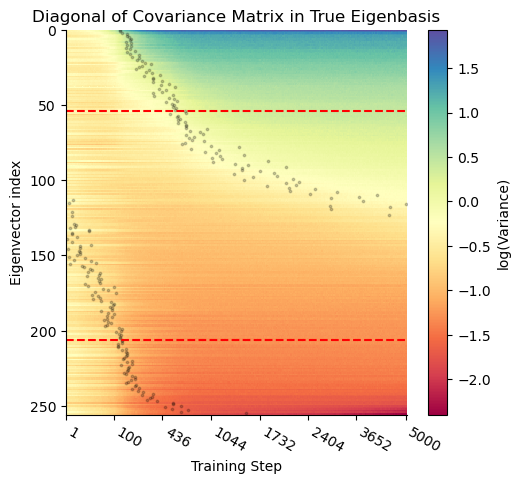

In [ ]:
plt.figure(figsize=(5.5, 5))
plt.pcolor(diag_cov_x_sample_true_eigenbasis_traj.log().cpu().numpy().T, cmap="Spectral", rasterized=True)
plt.colorbar(label="log(Variance)")
plt.scatter(emer_time_df["emergence_step"].to_numpy(), emer_time_df.index.to_numpy(), marker="o", c="k", s=3, alpha=0.2, rasterized=True)
plt.axhline(eig_idx_tooclose_vec[0], color="r", linestyle="--")
plt.axhline(eig_idx_tooclose_vec[-1], color="r", linestyle="--")
plt.title("Diagonal of Covariance Matrix in True Eigenbasis")
plt.xlabel("Training Step")
plt.ylabel("Eigenvector index")
plt.gca().invert_yaxis()  # Flip the y-axis
# annotate x-axis with step_slice
# Only show a subset of ticks to avoid overcrowding
tick_indices = np.linspace(0, len(step_slice)-1, 8, dtype=int)
plt.xticks(tick_indices, [step_slice[i] for i in tick_indices], rotation=-30, ha="left")
saveallforms(figdir, f"eigenframe_variance_heatmap_{expname}_rasterized", dpi=300)
plt.show()

In [ ]:
from core.trajectory_convergence_lib import fit_regression_log_scale, analyze_and_plot_variance

No crossing found for mode 120
No crossing found for mode 122
No crossing found for mode 125
No crossing found for mode 126
No crossing found for mode 127
No crossing found for mode 128
No crossing found for mode 137
No crossing found for mode 140
No crossing found for mode 142
Not enough data points to fit for direction: nan
Direction: increase
Slope: -1.08, Intercept: 6.70, R-squared: 0.92 (log-log) [N=64]
Equation: $y = 810.66 x^{-1.08}$
Direction: decrease
Slope: -1.08, Intercept: 3.43, R-squared: 0.91 (log-log) [N=63]
Equation: $y = 31.01 x^{-1.08}$


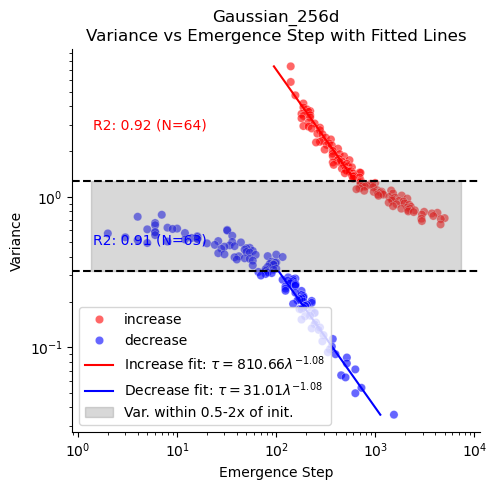

In [ ]:
emer_time_df_step = compute_crossing_points(img_eigval.cpu(), diag_cov_x_sample_true_eigenbasis_traj.cpu(), step_slice, smooth_sigma=1, threshold_type="geometric_mean")

init_var = diag_cov_x_sample_true_eigenbasis_traj[0,:]
mean_init_var = init_var.mean().item()
exclude_mask = (emer_time_df_step.Variance / mean_init_var > 0.5) & (emer_time_df_step.Variance / mean_init_var < 2)

analyze_and_plot_variance(emer_time_df_step, x_col="emergence_step", y_col="Variance", hue_col="Direction", log_x=True, log_y=True, figsize=(5, 5), 
                          exclude_mask=exclude_mask, reverse_equation=True, fit_label_format='{direction} fit: $\\tau = {a:.2f} \lambda^{{{b:.2f}}}$', 
                          title=f'{expname}\nVariance vs Emergence Step with Fitted Lines', xlabel='Emergence Step', ylabel='Variance', 
                          alpha=0.6, annotate=False, annotate_offset=(0, 0), fit_line_kwargs=None, 
                          scatter_kwargs={"rasterized": True, "linewidth": 0.3}, 
                          ax=None,
                          )
plt.axhline(0.5 * mean_init_var, color="k", linestyle="--")
plt.axhline(2 * mean_init_var, color="k", linestyle="--")
# fill the area between the two lines
XLIM = plt.gca().get_xlim()
plt.fill_betweenx([0.5 * mean_init_var, 2 * mean_init_var], [XLIM[0], XLIM[0]], [XLIM[1], XLIM[1]], 
                  color="gray", alpha=0.3, label="Var. within 0.5-2x of init.")
print("Direction: increase",)
df_split = emer_time_df_step[~exclude_mask].query("Direction == 'increase'")
fit_dict_increase = fit_regression_log_scale(df_split.Variance, df_split.emergence_step)
print("Direction: decrease",)
df_split = emer_time_df_step[~exclude_mask].query("Direction == 'decrease'")
fit_dict_decrease = fit_regression_log_scale(df_split.Variance, df_split.emergence_step)
# annotate the R2 of the fit
plt.text(0.05, 0.8, f"R2: {fit_dict_increase['r_squared']:.2f} (N={fit_dict_increase['N']})", transform=plt.gca().transAxes, ha="left", va="center", color="r")
plt.text(0.05, 0.5, f"R2: {fit_dict_decrease['r_squared']:.2f} (N={fit_dict_decrease['N']})", transform=plt.gca().transAxes, ha="left", va="center", color="blue")
plt.legend()
saveallforms(figdir, f"convergence_time_vs_variance_scaling_{expname}_rasterized", dpi=300)
plt.show()

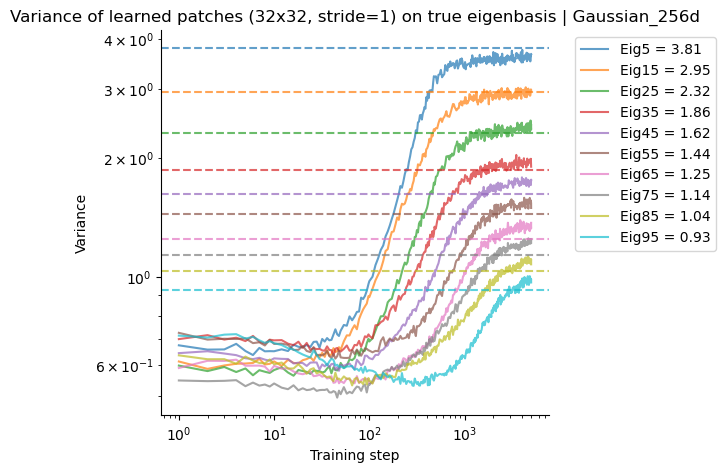

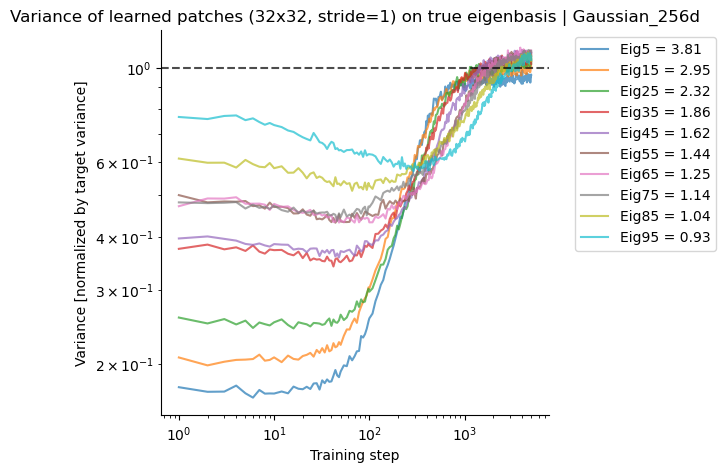

In [ ]:
plot_variance_trajectories(step_slice, diag_cov_x_sample_true_eigenbasis_traj.cpu(), img_eigval.cpu(), 
                           slice(5, 100, 10), 32, 1, figdir, expname, figsize=(5, 5))

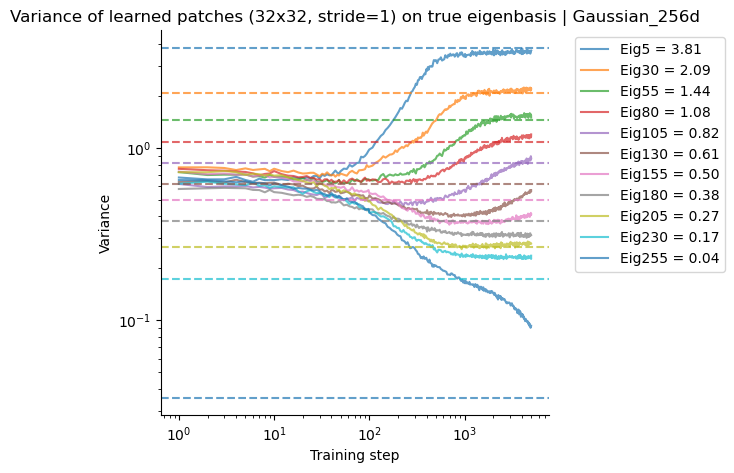

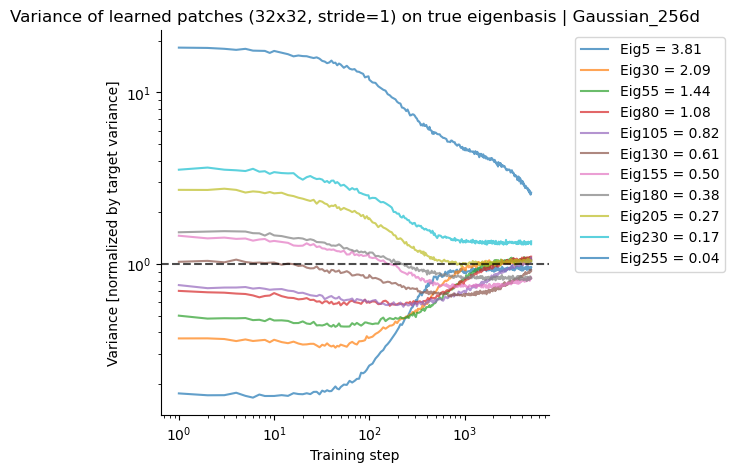

In [ ]:
plot_variance_trajectories(step_slice, diag_cov_x_sample_true_eigenbasis_traj.cpu(), img_eigval.cpu(), 
                           slice(5, 256, 25), 32, 1, figdir, expname, figsize=(5, 5))

### Scratch space

Estimated sample covariance trace 7.940922260284424
True covariance trace 4.999999523162842


Text(0.5, 1.0, 'Learned covariance at training step 2000\nestimated from samples')

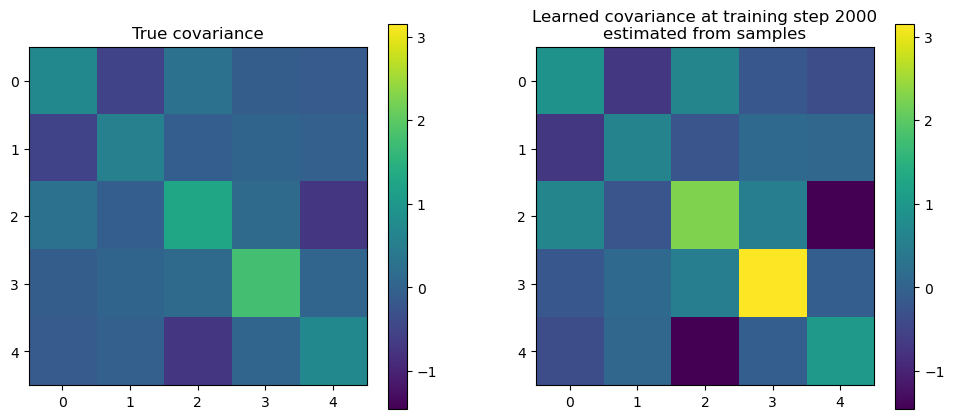

In [ ]:
training_step = 2000
x_traj, x0hat_traj, t_steps = sample_store[training_step]
cov_x_sample = torch.cov(x_traj[-1].T, correction=1) 
print("Estimated sample covariance trace", torch.diag(cov_x_sample).sum().item())
print("True covariance trace", torch.diag(cov).sum().item())
# print(x_traj.shape) # 21 x 10000 x 10
# print(x0hat_traj.shape) # 20 x 10000 x 10
# print(t_steps.shape) # 21

vmin = min(cov.cpu().numpy().min(), cov_x_sample.cpu().numpy().min())
vmax = max(cov.cpu().numpy().max(), cov_x_sample.cpu().numpy().max())
plt.figure(figsize=[12, 5])
plt.subplot(121)
plt.imshow(cov.cpu().numpy(), vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title("True covariance")
plt.subplot(122)
plt.imshow(cov_x_sample.cpu().numpy(), vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(f"Learned covariance at training step {training_step}\nestimated from samples")

In [ ]:
ndim = 10
# diag_var = torch.rand(ndim, device=device)
diag_var = torch.exp(torch.randn(ndim, device=device))
diag_var = torch.sort(diag_var, descending=True)[0]
diag_var = diag_var / diag_var.mean() 
diag_std = diag_var.sqrt()
cov = torch.diag(diag_var)
# rotate the covariance matrix with a random rotation matrix
# rot = torch.eye(ndim, device=device)
rot = torch.qr(torch.randn(ndim, ndim, device=device))[0]
cov = rot @ cov @ rot.T
pnts = torch.randn(10000, ndim).to(device)
pnts = pnts @ torch.diag(diag_std) @ rot.T
print(torch.trace(cov).item()) # ~ 10
print(torch.trace(torch.cov(pnts.T, correction=1)).item()) # ~ 13.2

10.0
10.027811050415039


In [ ]:
training_step = 1000
x_traj, x0hat_traj, t_steps = sample_store[training_step]
print(x_traj.shape) # 21 x 10000 x 10
print(x0hat_traj.shape) # 20 x 10000 x 10
print(t_steps.shape) # 21
# compute the covariance of the samples
cov_x_sample = torch.cov(x_traj[-1].T) 
print(cov_x_sample.shape) # 10 x 10
# compute the covariance of the samples
# cov_x0hat_final = torch.cov(x0hat_traj[-1])
# print(cov_x0hat_final.shape) # 10 x 10

torch.Size([41, 10000, 25])
torch.Size([40, 10000, 25])
torch.Size([41])
torch.Size([25, 25])


In [ ]:
torch.trace(torch.cov(pnts.T))

tensor(7.8858, device='cuda:0')

#### Scratch

In [ ]:
diag_cov_x_sample_true_eigenbasis_traj = []
step_slice = [*sample_store.keys()]
for training_step in step_slice:
    x_traj, x0hat_traj, t_steps = sample_store[training_step]
    cov_x_sample = torch.cov(x_traj[-1].T).to(device)
    # try estimate the variance along the eigenvector of the covariance matrix
    cov_x_sample_true_eigenbasis = rot.T @ cov_x_sample @ rot
    cov_true_eigenbasis = rot.T @ cov @ rot
    diag_cov_x_sample_true_eigenbasis = torch.diag(cov_x_sample_true_eigenbasis)
    diag_cov_true_eigenbasis = torch.diag(cov_true_eigenbasis)
    diag_cov_x_sample_true_eigenbasis_traj.append(diag_cov_x_sample_true_eigenbasis)
    
diag_cov_x_sample_true_eigenbasis_traj = torch.stack(diag_cov_x_sample_true_eigenbasis_traj).cpu()

pkl.dump({"diag_cov_x_sample_true_eigenbasis_traj": diag_cov_x_sample_true_eigenbasis_traj.cpu(), 
          "true_cov_eigs": true_cov_eigs.cpu(),
          "step_slice": step_slice}, open(f"{savedir}/sample_cov_true_eigenbasis_diag_traj.pkl", "wb"))

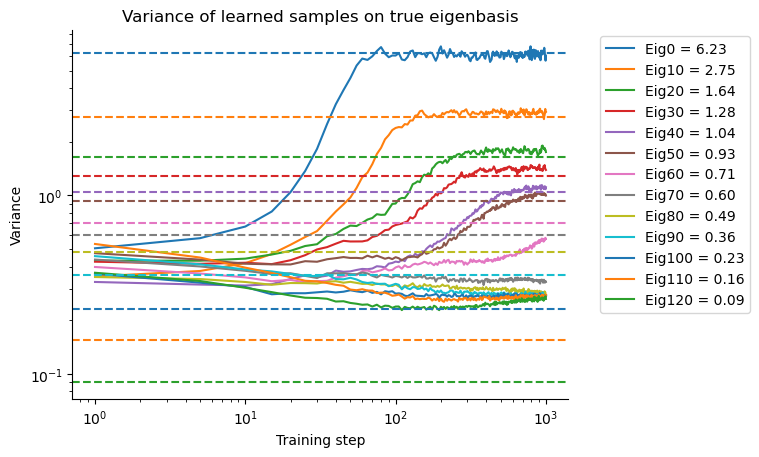

In [ ]:
true_cov_eigs = diag_cov_true_eigenbasis.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs)
slice2plot = slice(None, None, 10)
plt.plot(step_slice, diag_cov_x_sample_true_eigenbasis_traj[:, slice2plot])
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(true_cov_eigs[eigid].item(), color=f"C{i}", linestyle="--")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_raw")
plt.show()

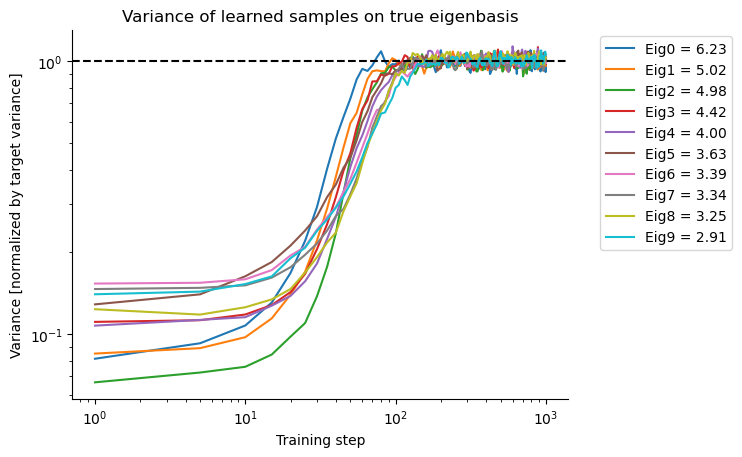

In [ ]:
true_cov_eigs = diag_cov_true_eigenbasis.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj.numpy() / true_cov_eigs.numpy())
slice2plot = slice(None, 10, 1)
plt.plot(step_slice, diag_cov_normalized[:, slice2plot])
plt.axhline(1, color="k", linestyle="--")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_normalized_top10")
plt.show()

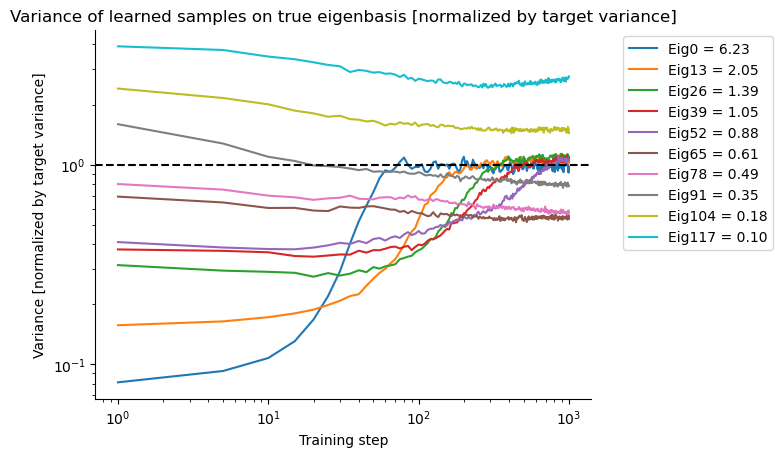

In [ ]:
true_cov_eigs = diag_cov_true_eigenbasis.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs).numpy()
slice2plot = slice(None, None, 13)
plt.plot(step_slice, diag_cov_normalized[:, slice2plot], )
plt.axhline(1, color="k", linestyle="--")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis [normalized by target variance]")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_normalized_every10")
plt.show()